In [47]:
from src.backend.lib.postgresql_client import Base, PostgresClient
from src.backend.lib.models import Article

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

# Query from DB

In [48]:
db = PostgresClient()
engine = db.engine

In [49]:
# Base.metadata.drop_all(bind=engine, tables=[Postgres_Article.__table__])

In [50]:
sql_query =f"""SELECT * FROM articles;"""
df = pd.read_sql_query(sql_query, engine)
df.head()

,article_id,title,href,publish_date,newspaper,category,author_id,author_fullname,content,related_articles,sentimental,keywords
0,1,A hypothetical weather forecast for 2050 is co...,/2022/07/15/weather/2050-uk-forecast-comes-tru...,2022-07-15,CNN,World,,"Analysis by Angela Fritz, CNN Senior Climate E...",The climate crisis is pushing weather to the e...,None,None,None
1,2,Filipinos are buying books to preserve the tru...,/2022/07/16/asia/philippines-marcos-books-trut...,2022-07-17,CNN,World,,"By Kathleen Magramo, CNN",The rush to buy books documenting Marcos' dest...,None,None,None
2,3,Exclusive: Russians have visited Iran at least...,/2022/07/15/politics/russian-visit-iran-weapon...,2022-07-16,CNN,World,,"By Natasha Bertrand, CNN",Iran began showcasing the Shahed-191 and Shahe...,None,None,None
3,4,Mexico detains drug lord wanted by US as 14 ki...,/2022/07/15/americas/mexico-rafael-caro-quinte...,2022-07-16,CNN,World,,"By Tara Subramaniam, Karol Suarez and Rey Rodr...",Rafael Caro Quintero was detained by Marines a...,None,None,None
4,5,"Ukraine's harvest becomes the new battlefield,...",/2022/07/11/europe/ukraine-harvest-battlefield...,2022-07-16,CNN,World,,"By Tim Lister and Petro Zadorozhnyy, CNN",The conflict's front lines straddle some of Uk...,None,None,None


## Stats

<AxesSubplot:title={'center':'Count'}, xlabel='Category', ylabel='Number of Articles'>

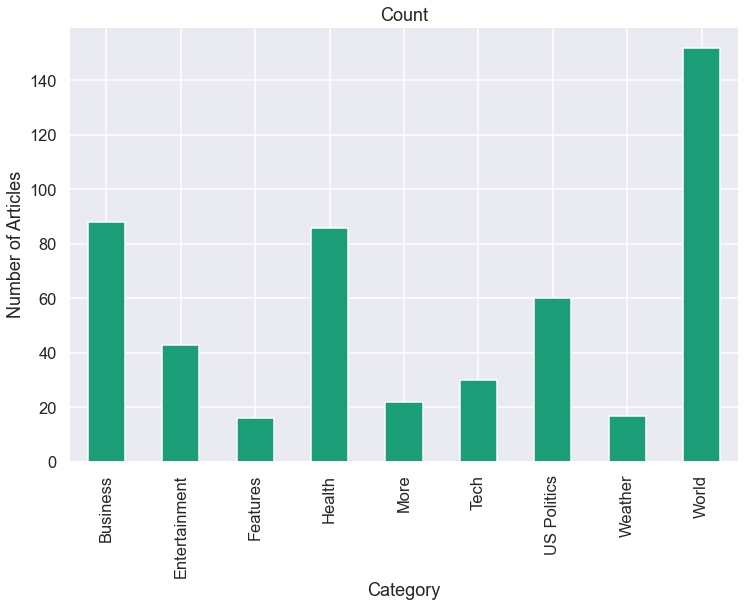

In [51]:
df_stats = df.groupby(["category"]).count()
df_stats["content"].plot(kind='bar', title='Count', ylabel='Number of Articles',
         xlabel='Category', figsize=(12, 8))

# Sentimental analysis

Do analysis with articles in Business:

- Apply a filter to choose only category Business.
- (Optional) filter out articles published more then n days ago.


In [53]:
from datetime import timedelta, date

published_in_n_latest_days = 5
df_business = df[(df.category == "Business") & ((date.today() - df.publish_date) < timedelta(days=published_in_n_latest_days))]
print(len(df_business))
df_business.head()

50


,article_id,title,href,publish_date,newspaper,category,author_id,author_fullname,content,related_articles,sentimental,keywords
107,107,How companies subtly trick users online with '...,/2022/07/16/tech/dark-patterns-what-to-know/in...,2022-07-16,CNN,Business,,"By Catherine Thorbecke, CNN Business","Countless popular websites and apps, from reta...",None,None,None
108,108,Americans are feeling slightly better about th...,/2022/07/15/economy/consumer-sentiment-july-pr...,2022-07-15,CNN,Business,,"By Alicia Wallace, CNN Business",The preliminary index for the university's Sur...,None,None,None
109,109,Energy saved US markets last quarter. Now the ...,/2022/07/15/investing/premarket-stocks-trading...,2022-07-15,CNN,Business,,"By Nicole Goodkind, CNN Business",A version of this story first appeared in CNN ...,None,None,None
110,110,Employers who want workers in the office more ...,/2022/07/15/success/hybrid-work-employees/inde...,2022-07-15,CNN,Business,,"By Kathryn Vasel, CNN Business","But some employees, who have spent the last tw...",None,None,None
111,111,"For the first time since 1989, the Super Bowl ...",/2022/07/15/business-food/anheuser-busch-molso...,2022-07-15,CNN,Business,,"By Ramishah Maruf, CNN Business",Anheuser-Busch is ending its more-than-33-year...,None,None,None


In [ ]:
list_title = df.title.values
list_content = df.content.values

## Sentimental analysis with nltk

In [54]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

Use the Vader Sentiment Analyzer in nltk to simply rank a piece of text as positive, negative or neutral using a lexicon of positive and negative words.

In [55]:
# nltk.download('vader_lexicon')

In [69]:
sia = SIA()
results = []

for content in list_title:
    pol_score = sia.polarity_scores(content)
    pol_score['content'] = content
    results.append(pol_score)

df_sia = pd.DataFrame.from_records(results)
df_sia.head()

,neg,neu,pos,compound,content
0,0.000,0.763,0.237,0.4215,A hypothetical weather forecast for 2050 is co...
1,0.000,0.827,0.173,0.3182,Filipinos are buying books to preserve the tru...
2,0.000,0.903,0.097,0.1280,Exclusive: Russians have visited Iran at least...
3,0.356,0.644,0.000,-0.8020,Mexico detains drug lord wanted by US as 14 ki...
4,0.191,0.809,0.000,-0.3818,"Ukraine's harvest becomes the new battlefield,..."


Compound ranges from -1 (extremely negative) to 1 (extremely positive). Choose threshold of 0.3 (-0.3) to decide whether it is neg/pos

In [70]:
df_sia['label'] = 0
df_sia.loc[df_sia['compound'] > 0.3, 'label'] = "positive"
df_sia.loc[df_sia['compound'] < -0.3, 'label'] = "negative"
df_sia.loc[df_sia['label'] == 0, 'label'] = "neutral"

df_sia.head()

,neg,neu,pos,compound,content,label
0,0.000,0.763,0.237,0.4215,A hypothetical weather forecast for 2050 is co...,positive
1,0.000,0.827,0.173,0.3182,Filipinos are buying books to preserve the tru...,positive
2,0.000,0.903,0.097,0.1280,Exclusive: Russians have visited Iran at least...,neutral
3,0.356,0.644,0.000,-0.8020,Mexico detains drug lord wanted by US as 14 ki...,negative
4,0.191,0.809,0.000,-0.3818,"Ukraine's harvest becomes the new battlefield,...",negative


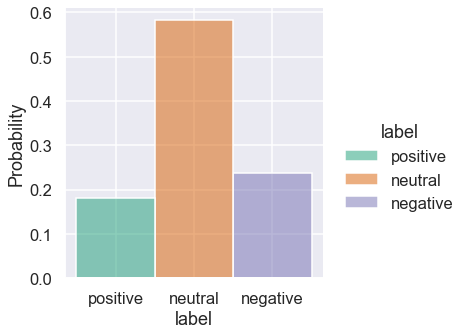

In [71]:
sns.displot(df_sia, x="label", hue="label",stat="probability")

In [72]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

# nltk.download('stopwords')

In [73]:
stop_words = stopwords.words('english')

In [74]:
def process_text(contents):
    tokens = []
    for content in contents:
        toks = tokenizer.tokenize(content)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [75]:
tokenizer = RegexpTokenizer(r'\w+')

pos_lines = df_sia[df_sia.label == "positive"].content.values

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('biden', 10),
 ('new', 9),
 ('could', 9),
 ('help', 6),
 ('reveals', 6),
 ('best', 6),
 ('monkeypox', 6),
 ('stay', 6),
 ('safe', 6),
 ('spreads', 6),
 ('nurse', 6),
 ('midwives', 6),
 ('fill', 6),
 ('gap', 6),
 ('prenatal', 6),
 ('care', 6),
 ('rural', 6),
 ('hospitals', 6),
 ('shut', 6),
 ('labor', 6)]

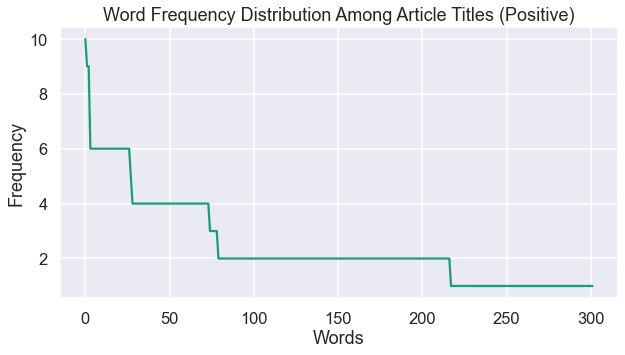

In [78]:
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution Among Article Titles (Positive)")
plt.show()

### Sentimental analysis with Transformers

Models from transformers module need pytorch or tensorflow to run. So make sure you have either of them installed. See more at https://huggingface.co/docs/transformers/index

In [79]:
from transformers import pipeline

In [80]:
# use pretrained distilbert model
sentiment_analysis = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are 

In [81]:
#test
print(sentiment_analysis("This restaurant is awesome"))
print(sentiment_analysis("This restaurant is awful"))

[{'label': 'POSITIVE', 'score': 0.9998743534088135}]
[{'label': 'NEGATIVE', 'score': 0.9996669292449951}]


<b>predict sentiment for all the titles</b>

For the Bert model, max size for input is 250. We'll need to cut the article into smaller chunks, then predict for each chunk and average out to get the final prediction for an article.

In [84]:
res = sentiment_analysis(list(df.title))

In [86]:
df["label"] = [r["label"] for r in res]
df["score"] = [r["score"] for r in res]
df[["title", "label","score"]]

,title,label,score
0,A hypothetical weather forecast for 2050 is co...,POSITIVE,0.971965
1,Filipinos are buying books to preserve the tru...,NEGATIVE,0.879084
2,Exclusive: Russians have visited Iran at least...,POSITIVE,0.797128
3,Mexico detains drug lord wanted by US as 14 ki...,NEGATIVE,0.980571
4,"Ukraine's harvest becomes the new battlefield,...",NEGATIVE,0.979885
...,...,...,...
509,'Zombies 3' makes it hard to get fired up for ...,NEGATIVE,0.998956
510,Gwen Stefani accused of cultural appropriation...,NEGATIVE,0.990949
511,J-Hope of BTS debuts solo album 'Jack in the Box',POSITIVE,0.989856
512,'Gremlins' director thinks Baby Yoda'was copie...,NEGATIVE,0.997793


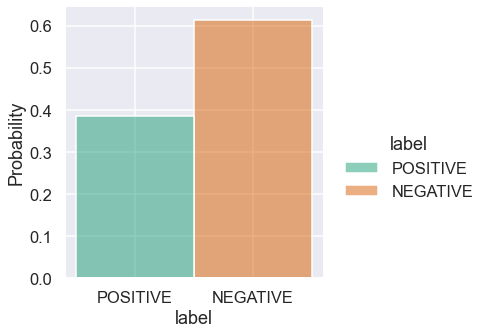

In [119]:
# plot overall distribution
sns.displot(df, x="label", hue="label",stat="probability")

<b>Plot number of negative/positive article over the last 10 days

In [113]:
# get article published in the last 10 days
df_recent10 = df[(date.today() - df.publish_date) < timedelta(days=10)]

In [114]:
df_agg = df_recent10.groupby(["publish_date","label"]).count()
df_agg

article_id  title  href  newspaper  category  \
publish_date label                                                    
2022-07-08   NEGATIVE           9      9     9          9         9   
             POSITIVE           2      2     2          2         2   
2022-07-09   NEGATIVE           1      1     1          1         1   
             POSITIVE           1      1     1          1         1   
2022-07-10   NEGATIVE           1      1     1          1         1   
2022-07-11   NEGATIVE           6      6     6          6         6   
             POSITIVE           3      3     3          3         3   
2022-07-12   NEGATIVE          10     10    10         10        10   
             POSITIVE           2      2     2          2         2   
2022-07-13   NEGATIVE          10     10    10         10        10   
             POSITIVE           4      4     4          4         4   
2022-07-14   NEGATIVE          82     82    82         82        82   
             POSITIVE          29     29    29         29        29   
2022-07-15   NEGATIVE          75     75    75         75        75   
             POSITIVE          50     50    50         50        50   
2022-07-16   NEGATIVE          51     51    51         51        51   
             POSITIVE          12     12    12         12        12   
2022-07-17   NEGATIVE          14     14    14         14        14   
             POSITIVE          56     56    56         56        56   

                       author_id  author_fullname  content  related_articles  \
publish_date label                                                             
2022-07-08   NEGATIVE          9                9        9                 0   
             POSITIVE          2                2        2                 0   
2022-07-09   NEGATIVE          1                1        1                 0   
             POSITIVE          1                1        1                 0   
2022-07-10   NEGATIVE          1                1        1                 0   
2022-07-11   NEGATIVE          6                6        6                 0   
             POSITIVE          3                3        3                 0   
2022-07-12   NEGATIVE         10               10       10                 0   
             POSITIVE          2                2        2                 0   
2022-07-13   NEGATIVE         10               10       10                 0   
             POSITIVE          4                4        4                 0   
2022-07-14   NEGATIVE         82               82       82                 0   
             POSITIVE         29               29       29                 0   
2022-07-15   NEGATIVE         75               75       75                 0   
             POSITIVE         50               50       50                 0   
2022-07-16   NEGATIVE         51               51       51                 0   
             POSITIVE         12               12       12                 0   
2022-07-17   NEGATIVE         14               14       14                 0   
             POSITIVE         56               56       56                 0   

                       sentimental  keywords  score  
publish_date label                                   
2022-07-08   NEGATIVE            0         0      9  
             POSITIVE            0         0      2  
2022-07-09   NEGATIVE            0         0      1  
             POSITIVE            0         0      1  
2022-07-10   NEGATIVE            0         0      1  
2022-07-11   NEGATIVE            0         0      6  
             POSITIVE            0         0      3  
2022-07-12   NEGATIVE            0         0     10  
             POSITIVE            0         0      2  
2022-07-13   NEGATIVE            0         0     10  
             POSITIVE            0         0      4  
2022-07-14   NEGATIVE            0         0     82  
             POSITIVE            0         0     29  
2022-07-15   NEGATIVE            0      

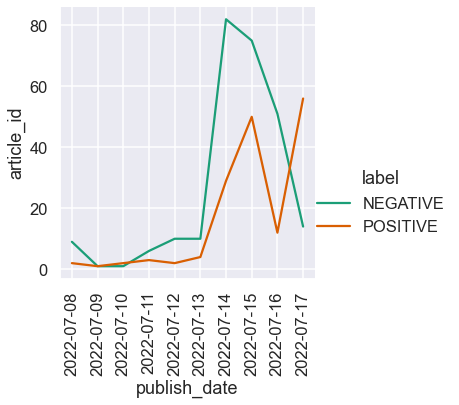

In [122]:
plot = sns.relplot(x="publish_date", y= "article_id", kind="line", hue="label", data=df_agg.reset_index())
plot.set_xticklabels(rotation=90)

<b>Plot distribution of neg/pos articles by category

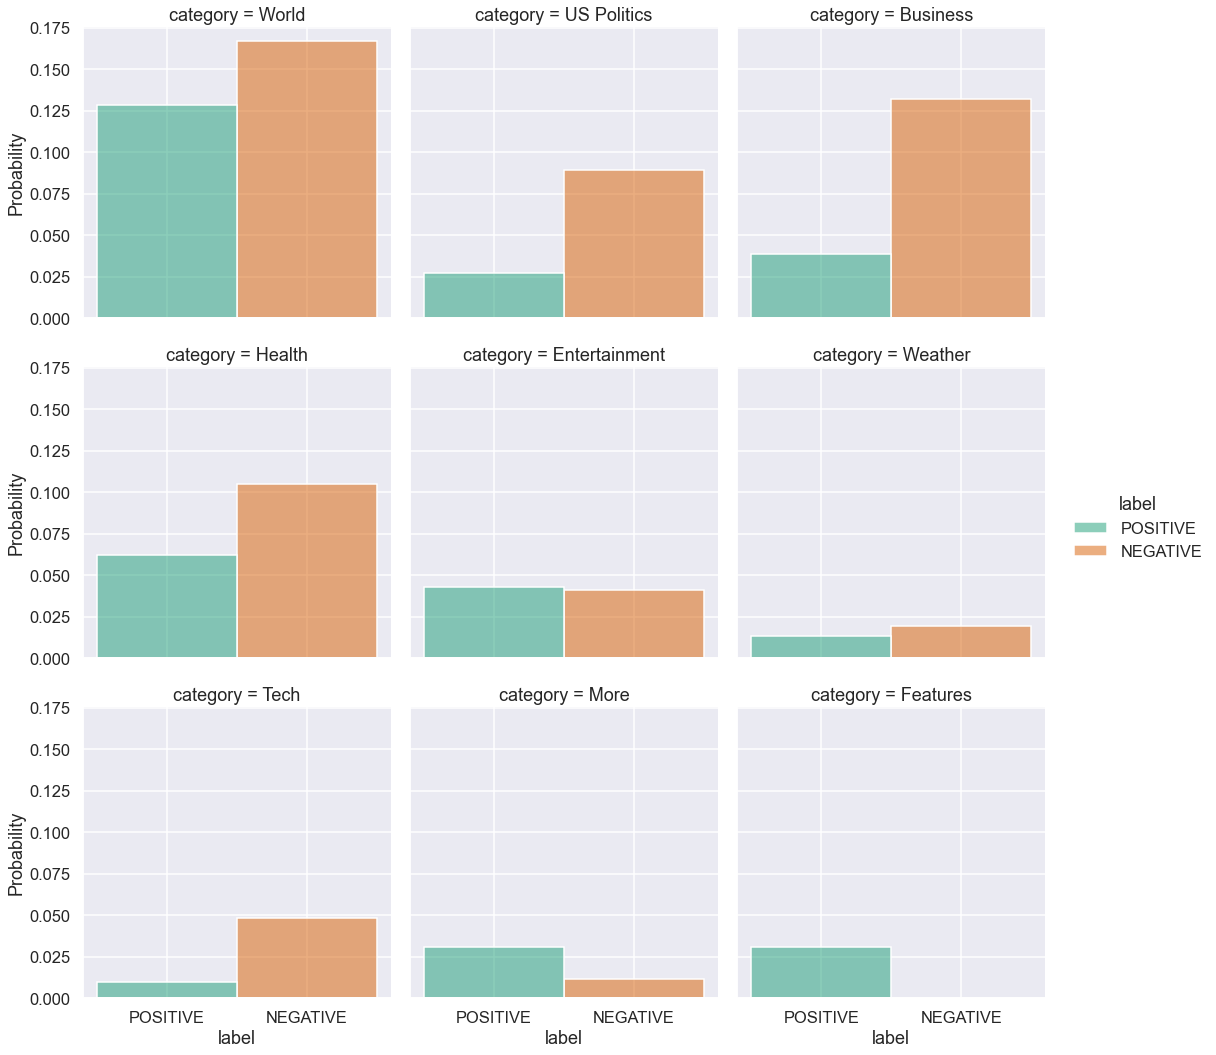

In [92]:
sns.displot(df, x="label", hue="label",stat="probability",col="category",col_wrap=3)

Overview:
- More negative than positive in both methods.
- politics, business have same distribution

## Correlation between categories

Some categories are correlated: Politics vs Business ...

## TO-DO

- Named Entity Recognition: analysis of Entity frequency

- Topic clustering:
    - Based on related articles (urls refered in the content)
    - Based on category + keyword similarity